## Part 1 : Classification with Original Colors


### 1.1 Load Train and Test Data in Original Colors:

We loaded the training and testing data, ensuring the images were resized to 32x32 pixels and converted to tensors.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Custom dataset class
class SportsBallsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0] + '.png')
        image = Image.open(img_name).convert('RGB')
        label = self.labels_df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Paths to the datasets
train_dir = '/home/k64769/SS24_AssignmentFinal/data/Train_Part1/Train'
test_dir = '/home/k64769/SS24_AssignmentFinal/data/Test_Part1/Test'
train_csv = os.path.join(train_dir, 'labels.csv')
test_csv = os.path.join(test_dir, 'labels.csv')

# Load datasets
train_dataset = SportsBallsDataset(csv_file=train_csv, root_dir=train_dir, transform=transform)
test_dataset = SportsBallsDataset(csv_file=test_csv, root_dir=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### 1.2 Visualize dataset

We visualized the dataset to understand the distribution and appearance of the images.

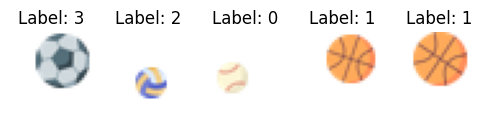

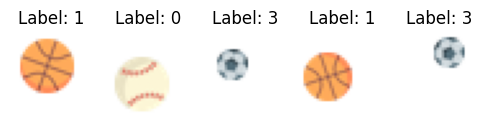

In [2]:
# Visualization function
def visualize_dataset(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        # Convert tensor to numpy for visualization
        image_np = image.permute(1, 2, 0).numpy()
        axes[i].imshow(image_np)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a few training images from Part 1
visualize_dataset(train_dataset, num_images=5)
visualize_dataset(test_dataset, num_images=5)

### 1.3 Define Classification Network

In [3]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(16 * 16 * 16, 64)
#         self.fc2 = nn.Linear(64, 4)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = x.view(-1, 16 * 16 * 16)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

We used a simple Convolutional Neural Network (CNN) for the initial classification. The architecture includes:


Convolutional layer with 16 filters

Max-pooling layer

Fully connected layer with 64 neurons

Output layer with 4 neurons (one for each class)

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8 * 16 * 16, 32)
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 8 * 16 * 16)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model and move it to the device (GPU if available)
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


### 1.4 Training function of Classification Network

We trained the model for 10 epochs, recording the loss and accuracy.

In [6]:
# Training function 
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

### 1.5 Evaluation Function

We evaluated the model on the test data, plotting the confusion matrix and calculating accuracy.

In [7]:
# Evaluation function with confusion matrix and saving predictions
def evaluate_model(model, test_loader, output_file):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # Save predictions to CSV
    df = pd.DataFrame({'True Labels': all_labels, 'Predicted Labels': all_preds})
    df.to_csv(output_file, index=False)
    print(f'Saved predictions to {output_file}')

    #Return statement removed to prevent printing of predictions
    return all_preds, all_labels


### 1.6 Train and Evaluate 

Epoch [1/10], Loss: 0.8956
Epoch [2/10], Loss: 0.3884
Epoch [3/10], Loss: 0.1530
Epoch [4/10], Loss: 0.0610
Epoch [5/10], Loss: 0.0304
Epoch [6/10], Loss: 0.0165
Epoch [7/10], Loss: 0.0104
Epoch [8/10], Loss: 0.0070
Epoch [9/10], Loss: 0.0048
Epoch [10/10], Loss: 0.0034
Accuracy: 100.00%


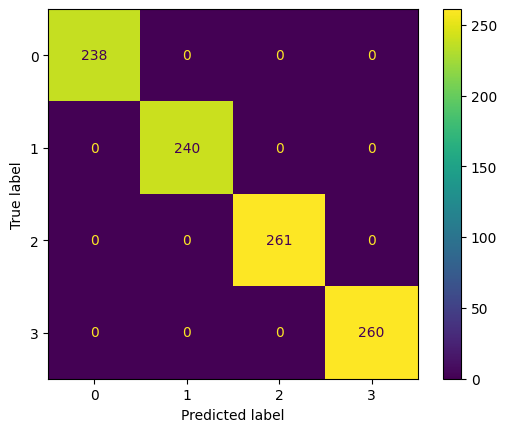

Saved predictions to pred_part1.csv


In [8]:
# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, epochs=10)
preds, labels = evaluate_model(model, test_loader, 'pred_part1.csv')

### 1.7 Predictions

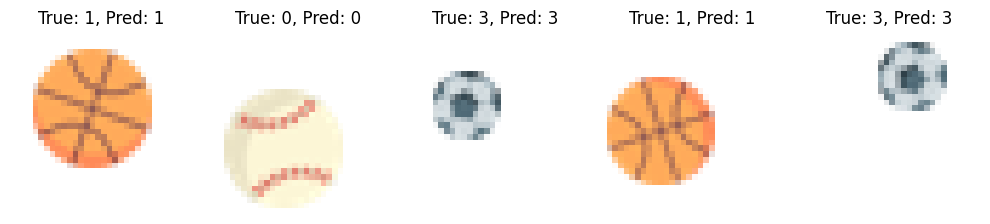

In [9]:
# Show predictions for a few test images
def show_predictions(test_loader, preds, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    for i in range(num_images):
        image, label = test_loader.dataset[i]
        image_np = image.permute(1, 2, 0).numpy()
        axes[i].imshow(image_np)
        axes[i].set_title(f'True: {labels[i]}, Pred: {preds[i]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(test_loader, preds, labels, num_images=5)


## Part 2: Classification with Random Colormap

### 2.1 Load Mixed-Color Dataset

We generated and loaded mixed-color datasets with random color maps.

In [10]:
# Load mixed-color datasets
train_dir_mixed = '/home/k64769/SS24_AssignmentFinal/data/Train_Part2/Train'
test_dir_mixed = '/home/k64769/SS24_AssignmentFinal/data/Test_Part2/Test'
train_csv_mixed = os.path.join(train_dir_mixed, 'labels.csv')
test_csv_mixed = os.path.join(test_dir_mixed, 'labels.csv')

train_dataset_mixed = SportsBallsDataset(csv_file=train_csv_mixed, root_dir=train_dir_mixed, transform=transform)
test_dataset_mixed = SportsBallsDataset(csv_file=test_csv_mixed, root_dir=test_dir_mixed, transform=transform)

train_loader_mixed = DataLoader(train_dataset_mixed, batch_size=32, shuffle=True)
test_loader_mixed = DataLoader(test_dataset_mixed, batch_size=32, shuffle=False)


### 2.2 Visualize Mixed-Color Dataset 

We visualized the mixed-color dataset to understand the variations introduced by the random color maps.

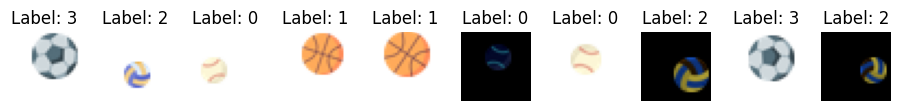

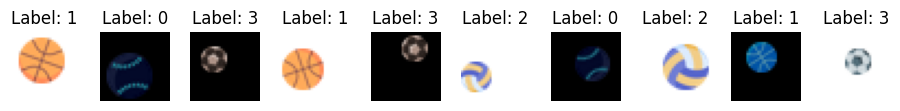

In [11]:
import matplotlib.pyplot as plt

def visualize_mixed_dataset(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))  # Adjusted figsize for better spacing
    fig.tight_layout(pad=3.0)  # Add padding between subplots

    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.permute(1, 2, 0))  # Convert image tensor to numpy array
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.3)  # Adjust horizontal spacing between subplots
    plt.show()
    
# Visualize a few training images from Part 2 (Mixed-Color Dataset)
visualize_mixed_dataset(train_dataset_mixed, num_images=10)
visualize_mixed_dataset(test_dataset_mixed, num_images=10)

### 2.3 Evaluate Original Model on Mixed-Color Test Data

We evaluated the original model trained on original color images data with the mixed-color test data.

Accuracy: 71.27%


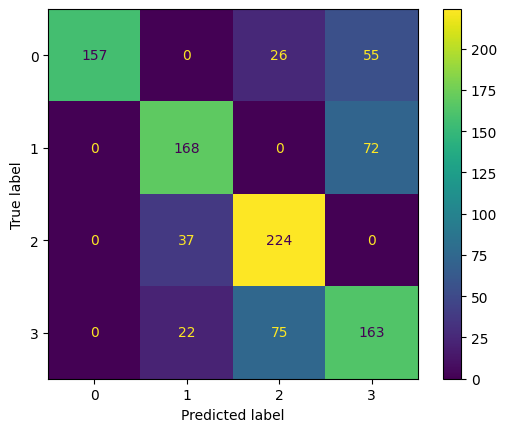

Saved predictions to pred_part2_1.csv


([1,
  3,
  2,
  1,
  2,
  2,
  3,
  2,
  3,
  3,
  3,
  3,
  2,
  3,
  2,
  2,
  0,
  0,
  3,
  3,
  0,
  2,
  2,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  3,
  0,
  0,
  1,
  1,
  3,
  1,
  2,
  0,
  1,
  3,
  2,
  3,
  3,
  2,
  2,
  2,
  1,
  2,
  1,
  2,
  0,
  3,
  3,
  1,
  1,
  2,
  2,
  0,
  3,
  2,
  2,
  1,
  3,
  3,
  0,
  2,
  3,
  0,
  1,
  3,
  3,
  3,
  3,
  2,
  1,
  1,
  2,
  2,
  0,
  3,
  3,
  2,
  1,
  1,
  0,
  3,
  3,
  0,
  2,
  2,
  2,
  0,
  3,
  3,
  1,
  0,
  0,
  3,
  2,
  0,
  0,
  2,
  3,
  2,
  2,
  2,
  3,
  3,
  3,
  1,
  2,
  0,
  3,
  2,
  2,
  2,
  1,
  2,
  3,
  3,
  0,
  0,
  2,
  2,
  1,
  2,
  1,
  1,
  2,
  0,
  1,
  2,
  1,
  0,
  0,
  3,
  0,
  1,
  2,
  3,
  2,
  2,
  2,
  3,
  0,
  2,
  2,
  3,
  0,
  3,
  3,
  2,
  0,
  3,
  1,
  1,
  1,
  3,
  0,
  1,
  3,
  2,
  2,
  0,
  3,
  2,
  2,
  3,
  2,
  2,
  1,
  3,
  0,
  2,
  3,
  2,
  1,
  2,
  1,
  3,
  2,
  2,
  2,
  3,
  3,
  0,
  2,
  1,
  3,
  0,
  2,
  2,
  0,
  1,
  2,
  2,
  2,
  3,
  3,


In [12]:
# Evaluate Original Model on Mixed-Color Test Data
evaluate_model(model, test_loader_mixed, 'pred_part2_1.csv')

### 2.4 Fine-Tune Original Model on Mixed-Color Data

We fine-tuned the original model using 100 mixed-color training images.

Fine-Tuning Epoch [1/5], Loss: 2.9844
Fine-Tuning Epoch [2/5], Loss: 1.6786
Fine-Tuning Epoch [3/5], Loss: 1.5774
Fine-Tuning Epoch [4/5], Loss: 1.4695
Fine-Tuning Epoch [5/5], Loss: 2.3567
Accuracy: 74.47%


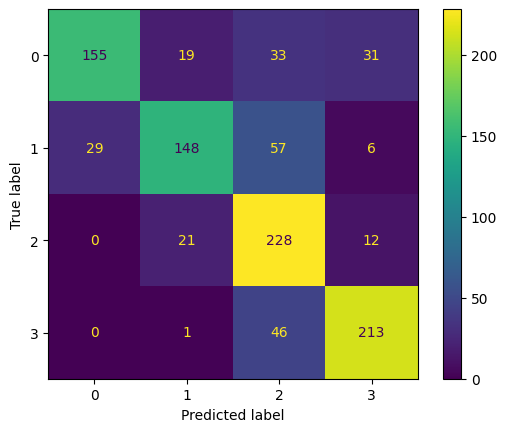

Saved predictions to pred_part2_2.csv


([1,
  3,
  2,
  1,
  2,
  2,
  2,
  2,
  1,
  3,
  2,
  1,
  2,
  3,
  2,
  2,
  0,
  0,
  3,
  3,
  0,
  2,
  2,
  0,
  0,
  1,
  0,
  1,
  0,
  2,
  2,
  0,
  0,
  2,
  1,
  3,
  1,
  2,
  0,
  2,
  3,
  2,
  1,
  3,
  2,
  2,
  2,
  1,
  3,
  0,
  2,
  0,
  3,
  3,
  1,
  1,
  2,
  2,
  0,
  1,
  2,
  2,
  1,
  1,
  3,
  0,
  2,
  3,
  0,
  1,
  2,
  3,
  3,
  3,
  1,
  0,
  3,
  2,
  2,
  0,
  3,
  3,
  2,
  2,
  1,
  0,
  2,
  3,
  0,
  2,
  2,
  2,
  0,
  3,
  3,
  1,
  0,
  0,
  3,
  3,
  0,
  0,
  1,
  3,
  2,
  3,
  2,
  3,
  2,
  3,
  3,
  2,
  0,
  3,
  1,
  2,
  2,
  1,
  2,
  3,
  3,
  0,
  2,
  2,
  2,
  0,
  1,
  0,
  1,
  2,
  0,
  0,
  2,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  3,
  2,
  2,
  2,
  2,
  0,
  1,
  2,
  3,
  0,
  3,
  3,
  2,
  0,
  3,
  2,
  2,
  2,
  3,
  0,
  2,
  3,
  2,
  2,
  0,
  1,
  2,
  2,
  3,
  2,
  1,
  0,
  3,
  0,
  2,
  3,
  2,
  1,
  1,
  1,
  3,
  2,
  2,
  3,
  3,
  2,
  0,
  2,
  2,
  3,
  0,
  1,
  3,
  0,
  1,
  2,
  2,
  2,
  3,
  2,


In [30]:
def fine_tune_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Fine-Tuning Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

train_dataset_mixed_100 = torch.utils.data.Subset(train_dataset_mixed, list(range(100)))
train_loader_mixed_100 = DataLoader(train_dataset_mixed_100, batch_size=32, shuffle=True)

# Use a lower learning rate for fine-tuning
fine_tune_optimizer = optim.Adam(model.parameters(), lr= 0.001)
fine_tune_model(model, train_loader_mixed_100, criterion, fine_tune_optimizer, epochs=5)

# Evaluate the fine-tuned model on the mixed-color test data
evaluate_model(model, test_loader_mixed, 'pred_part2_2.csv')


### 2.5 Train a New Model on Mixed-Color Data

In [14]:
class MixedCNN(nn.Module):
    def __init__(self):
        super(MixedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

We trained a new MixedCNN model on the mixed-color training data.

Epoch [1/10], Loss: 0.5991
Epoch [2/10], Loss: 0.0497
Epoch [3/10], Loss: 0.0136
Epoch [4/10], Loss: 0.0049
Epoch [5/10], Loss: 0.0026
Epoch [6/10], Loss: 0.0015
Epoch [7/10], Loss: 0.0010
Epoch [8/10], Loss: 0.0007
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0004
Accuracy: 100.00%


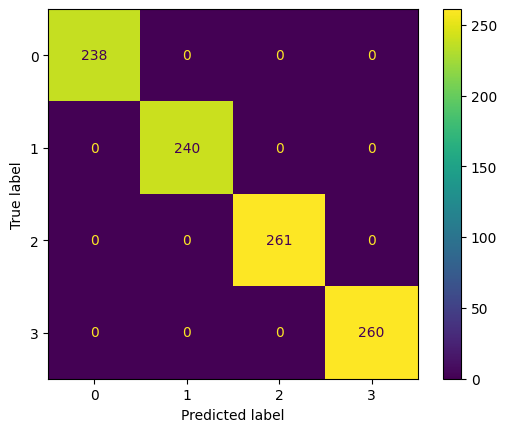

Saved predictions to pred_part2_3.csv


([1,
  0,
  3,
  1,
  3,
  2,
  0,
  2,
  1,
  3,
  1,
  1,
  2,
  3,
  2,
  2,
  0,
  0,
  3,
  0,
  0,
  2,
  2,
  0,
  0,
  1,
  0,
  1,
  0,
  2,
  1,
  0,
  0,
  2,
  1,
  3,
  1,
  2,
  0,
  1,
  3,
  2,
  1,
  3,
  2,
  2,
  2,
  1,
  3,
  1,
  3,
  0,
  3,
  3,
  1,
  1,
  3,
  2,
  0,
  1,
  3,
  2,
  1,
  1,
  3,
  0,
  2,
  3,
  0,
  1,
  1,
  3,
  3,
  3,
  2,
  1,
  3,
  2,
  2,
  0,
  3,
  3,
  2,
  2,
  1,
  0,
  0,
  3,
  0,
  2,
  2,
  2,
  0,
  3,
  3,
  1,
  0,
  0,
  3,
  2,
  0,
  0,
  2,
  3,
  3,
  3,
  2,
  0,
  1,
  3,
  3,
  2,
  0,
  3,
  0,
  2,
  2,
  1,
  2,
  3,
  1,
  0,
  0,
  2,
  2,
  1,
  2,
  1,
  1,
  2,
  0,
  1,
  2,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  3,
  2,
  2,
  2,
  1,
  0,
  0,
  2,
  3,
  0,
  3,
  3,
  2,
  0,
  3,
  2,
  2,
  2,
  3,
  0,
  2,
  3,
  2,
  2,
  0,
  1,
  2,
  3,
  3,
  2,
  0,
  1,
  3,
  0,
  2,
  3,
  2,
  1,
  3,
  1,
  0,
  2,
  2,
  3,
  3,
  0,
  0,
  2,
  1,
  0,
  0,
  2,
  3,
  0,
  1,
  2,
  2,
  2,
  3,
  0,


In [15]:
# Train a New Model on Mixed-Color Data
model_mixed = MixedCNN().to(device)
optimizer_mixed = optim.Adam(model_mixed.parameters(), lr=0.001)

train_model(model_mixed, train_loader_mixed, criterion, optimizer_mixed, epochs=10)
evaluate_model(model_mixed, test_loader_mixed, 'pred_part2_3.csv')


### 2.6 Evaluate New Model on Original Test Data

We evaluated the new model trained on mixed-color data using the original test data.

Accuracy: 100.00%


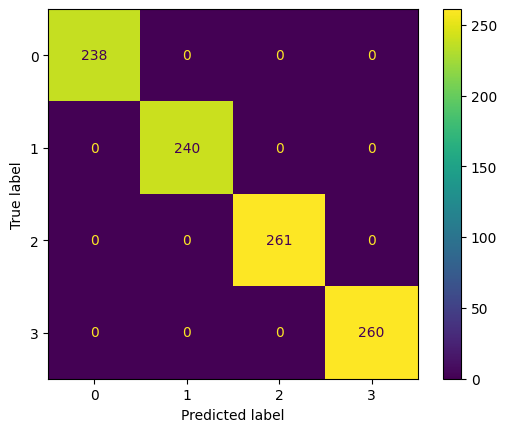

Saved predictions to pred_part2_4.csv


([1,
  0,
  3,
  1,
  3,
  2,
  0,
  2,
  1,
  3,
  1,
  1,
  2,
  3,
  2,
  2,
  0,
  0,
  3,
  0,
  0,
  2,
  2,
  0,
  0,
  1,
  0,
  1,
  0,
  2,
  1,
  0,
  0,
  2,
  1,
  3,
  1,
  2,
  0,
  1,
  3,
  2,
  1,
  3,
  2,
  2,
  2,
  1,
  3,
  1,
  3,
  0,
  3,
  3,
  1,
  1,
  3,
  2,
  0,
  1,
  3,
  2,
  1,
  1,
  3,
  0,
  2,
  3,
  0,
  1,
  1,
  3,
  3,
  3,
  2,
  1,
  3,
  2,
  2,
  0,
  3,
  3,
  2,
  2,
  1,
  0,
  0,
  3,
  0,
  2,
  2,
  2,
  0,
  3,
  3,
  1,
  0,
  0,
  3,
  2,
  0,
  0,
  2,
  3,
  3,
  3,
  2,
  0,
  1,
  3,
  3,
  2,
  0,
  3,
  0,
  2,
  2,
  1,
  2,
  3,
  1,
  0,
  0,
  2,
  2,
  1,
  2,
  1,
  1,
  2,
  0,
  1,
  2,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  3,
  2,
  2,
  2,
  1,
  0,
  0,
  2,
  3,
  0,
  3,
  3,
  2,
  0,
  3,
  2,
  2,
  2,
  3,
  0,
  2,
  3,
  2,
  2,
  0,
  1,
  2,
  3,
  3,
  2,
  0,
  1,
  3,
  0,
  2,
  3,
  2,
  1,
  3,
  1,
  0,
  2,
  2,
  3,
  3,
  0,
  0,
  2,
  1,
  0,
  0,
  2,
  3,
  0,
  1,
  2,
  2,
  2,
  3,
  0,


In [16]:
# Evaluate New Model on Original Test Data
evaluate_model(model_mixed, test_loader, 'pred_part2_4.csv')


### 2.7 Fine-Tune New Model on Original Color Data

We fine-tuned the new model using 100 original-color training images and evaluated it again.

Fine-Tuning Epoch [1/5], Loss: 0.0002
Fine-Tuning Epoch [2/5], Loss: 0.0002
Fine-Tuning Epoch [3/5], Loss: 0.0002
Fine-Tuning Epoch [4/5], Loss: 0.0002
Fine-Tuning Epoch [5/5], Loss: 0.0002
Accuracy: 100.00%


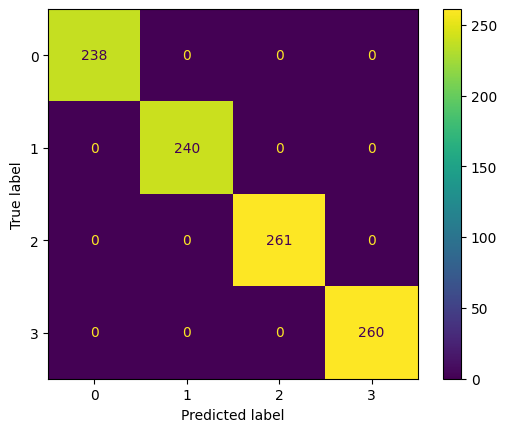

Saved predictions to pred_part2_5.csv


([1,
  0,
  3,
  1,
  3,
  2,
  0,
  2,
  1,
  3,
  1,
  1,
  2,
  3,
  2,
  2,
  0,
  0,
  3,
  0,
  0,
  2,
  2,
  0,
  0,
  1,
  0,
  1,
  0,
  2,
  1,
  0,
  0,
  2,
  1,
  3,
  1,
  2,
  0,
  1,
  3,
  2,
  1,
  3,
  2,
  2,
  2,
  1,
  3,
  1,
  3,
  0,
  3,
  3,
  1,
  1,
  3,
  2,
  0,
  1,
  3,
  2,
  1,
  1,
  3,
  0,
  2,
  3,
  0,
  1,
  1,
  3,
  3,
  3,
  2,
  1,
  3,
  2,
  2,
  0,
  3,
  3,
  2,
  2,
  1,
  0,
  0,
  3,
  0,
  2,
  2,
  2,
  0,
  3,
  3,
  1,
  0,
  0,
  3,
  2,
  0,
  0,
  2,
  3,
  3,
  3,
  2,
  0,
  1,
  3,
  3,
  2,
  0,
  3,
  0,
  2,
  2,
  1,
  2,
  3,
  1,
  0,
  0,
  2,
  2,
  1,
  2,
  1,
  1,
  2,
  0,
  1,
  2,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  3,
  2,
  2,
  2,
  1,
  0,
  0,
  2,
  3,
  0,
  3,
  3,
  2,
  0,
  3,
  2,
  2,
  2,
  3,
  0,
  2,
  3,
  2,
  2,
  0,
  1,
  2,
  3,
  3,
  2,
  0,
  1,
  3,
  0,
  2,
  3,
  2,
  1,
  3,
  1,
  0,
  2,
  2,
  3,
  3,
  0,
  0,
  2,
  1,
  0,
  0,
  2,
  3,
  0,
  1,
  2,
  2,
  2,
  3,
  0,


In [17]:
# Sample 100 images for fine-tuning
train_dataset_100 = torch.utils.data.Subset(train_dataset, list(range(100)))
train_loader_100 = DataLoader(train_dataset_100, batch_size=32, shuffle=True)

# Fine-tune the new model with 100 original-color images
fine_tune_model(model_mixed, train_loader_100, criterion, optimizer_mixed, epochs=5)
evaluate_model(model_mixed, test_loader, 'pred_part2_5.csv')

### 2.8 Show Predictions

We showed predictions for both mixed-color and original test images after fine-tuning.

Accuracy: 100.00%


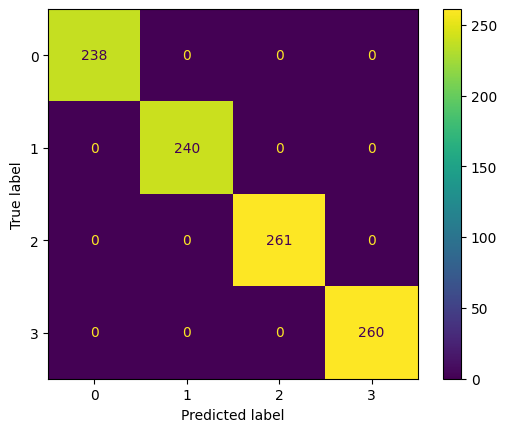

Saved predictions to pred_part2_mixed.csv


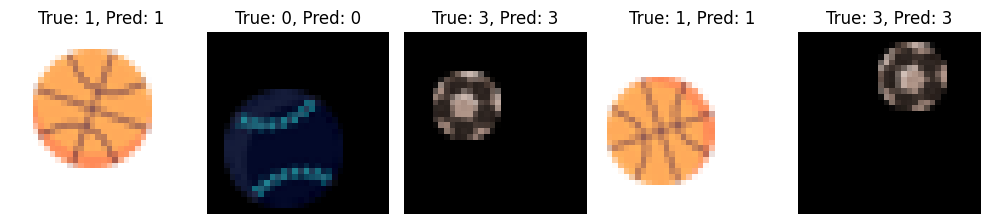

Accuracy: 100.00%


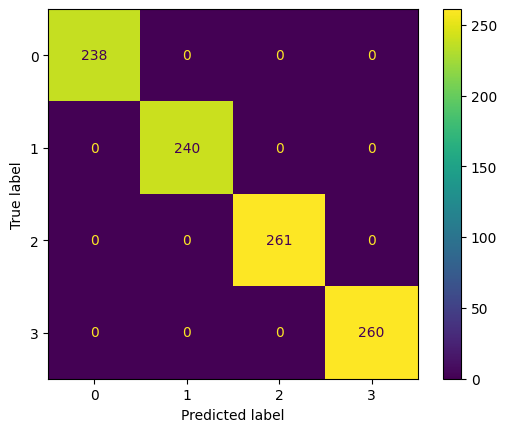

Saved predictions to pred_part2_orig.csv


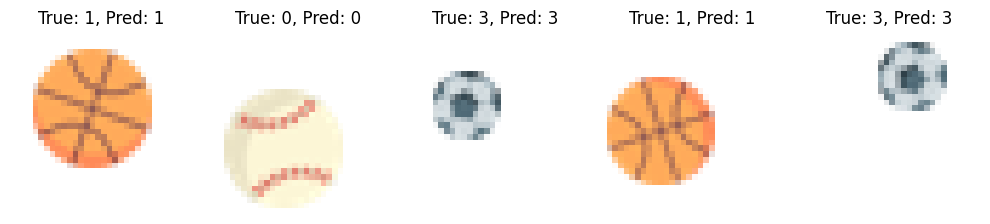

In [18]:

# Show Predictions for Mixed-Color Test Images
preds_mixed, labels_mixed = evaluate_model(model_mixed, test_loader_mixed, 'pred_part2_mixed.csv')
show_predictions(test_loader_mixed, preds_mixed, labels_mixed, num_images=5)

# Show Predictions for Original Test Images after Fine-Tuning
preds_orig, labels_orig = evaluate_model(model_mixed, test_loader, 'pred_part2_orig.csv')
show_predictions(test_loader, preds_orig, labels_orig, num_images=5)

## Part 3: Dual-Label Classification

### 3.1 Load Dual-Label Dataset

We loaded the dual-label dataset, which includes labels for both sports ball type and colormap type.

In [19]:
class SportsBallsDualLabelDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0] + '.png')
        image = Image.open(img_name).convert('RGB')  # Ensure image is in RGB format
        label_sportsball = self.labels_df.iloc[idx, 1]
        label_colormap = self.labels_df.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        return image, (label_sportsball, label_colormap)

# Load dual-label datasets
train_dir_dual = '/home/k64769/SS24_AssignmentFinal/data/Train_Part3/Train'
test_dir_dual = '/home/k64769/SS24_AssignmentFinal/data/Test_Part3/Test'
train_csv_dual = os.path.join(train_dir_dual, 'labels.csv')
test_csv_dual = os.path.join(test_dir_dual, 'labels.csv')

train_dataset_dual = SportsBallsDualLabelDataset(csv_file=train_csv_dual, root_dir=train_dir_dual, transform=transform)
test_dataset_dual = SportsBallsDualLabelDataset(csv_file=test_csv_dual, root_dir=test_dir_dual, transform=transform)

train_loader_dual = DataLoader(train_dataset_dual, batch_size=32, shuffle=True)
test_loader_dual = DataLoader(test_dataset_dual, batch_size=32, shuffle=False)


### 3.2 Visualize Dual-Label Dataset

We visualized the dual-label dataset to understand the distribution of both labels.

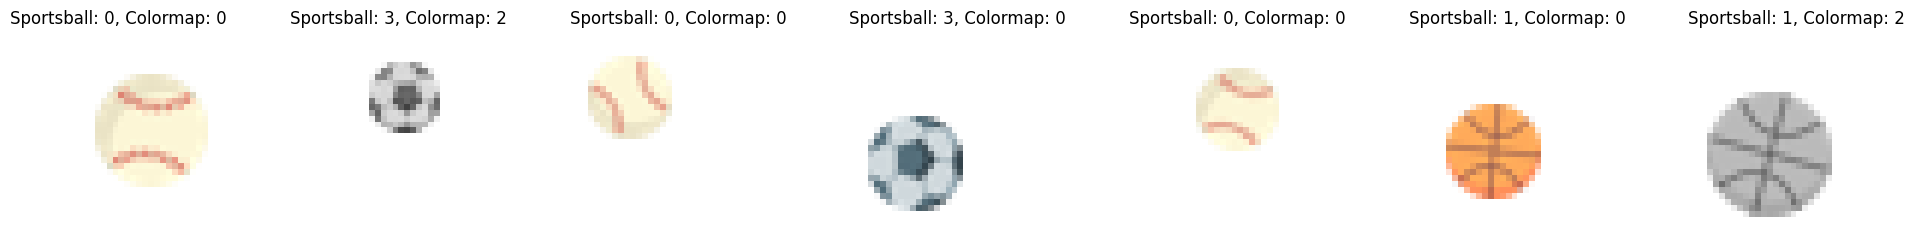

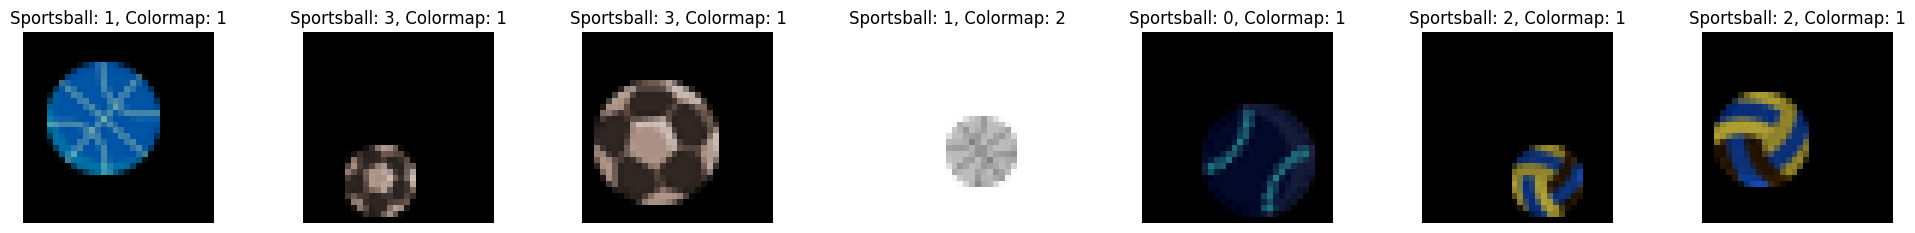

In [20]:
import matplotlib.pyplot as plt

def visualize_dual_dataset(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    fig.tight_layout(pad=3.0)
    for i in range(num_images):
        image, (label_sportsball, label_colormap) = dataset[i]
        axes[i].imshow(image.permute(1, 2, 0))  # Convert image tensor to numpy array
        axes[i].set_title(f'Sportsball: {label_sportsball}, Colormap: {label_colormap}')
        axes[i].axis('off')
    plt.show()
    
# Visualize a few training images from Part 3 (Dual-Label Dataset)
visualize_dual_dataset(train_dataset_dual, num_images=7)
visualize_dual_dataset(test_dataset_dual, num_images=7)

### 3.3 Define Dual-Label Classification Network

We used a simple dual-label CNN for classification, with shared convolutional layers and separate fully connected layers for each label.

In [21]:
class DualLabelCNN(nn.Module):
    def __init__(self):
        super(DualLabelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc_shared = nn.Linear(8 * 16 * 16, 64)  
        self.fc_sportsball = nn.Linear(64, 4)
        self.fc_colormap = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 8 * 16 * 16)  
        x = F.relu(self.fc_shared(x))
        sportsball = self.fc_sportsball(x)
        colormap = self.fc_colormap(x)
        return sportsball, colormap
    

# Initialize the dual-label model and move it to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dual = DualLabelCNN().to(device)
criterion_sportsball = nn.CrossEntropyLoss()
criterion_colormap = nn.CrossEntropyLoss()
optimizer_dual = optim.Adam(model_dual.parameters(), lr=0.001)

### 3.4 Train and Evaluate Dual-Label Model

We trained and evaluated the dual-label model, calculating accuracy for both labels.

In [22]:
# Train and evaluate dual-label model
def train_dual_model(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, (labels_sportsball, labels_colormap) in train_loader:
            images, labels_sportsball, labels_colormap = images.to(device), labels_sportsball.to(device), labels_colormap.to(device)
            optimizer.zero_grad()
            outputs_sportsball, outputs_colormap = model(images)
            loss_sportsball = criterion_sportsball(outputs_sportsball, labels_sportsball)
            loss_colormap = criterion_colormap(outputs_colormap, labels_colormap)
            loss = loss_sportsball + loss_colormap
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

def evaluate_dual_model(model, test_loader, output_file):
    model.eval()
    correct_sportsball = 0
    correct_colormap = 0
    total = 0
    all_preds_sportsball = []
    all_preds_colormap = []
    all_labels_sportsball = []
    all_labels_colormap = []
    with torch.no_grad():
        for images, (labels_sportsball, labels_colormap) in test_loader:
            images, labels_sportsball, labels_colormap = images.to(device), labels_sportsball.to(device), labels_colormap.to(device)
            outputs_sportsball, outputs_colormap = model(images)
            _, predicted_sportsball = torch.max(outputs_sportsball.data, 1)
            _, predicted_colormap = torch.max(outputs_colormap.data, 1)
            total += labels_sportsball.size(0)
            correct_sportsball += (predicted_sportsball == labels_sportsball).sum().item()
            correct_colormap += (predicted_colormap == labels_colormap).sum().item()
            all_preds_sportsball.extend(predicted_sportsball.cpu().numpy())
            all_preds_colormap.extend(predicted_colormap.cpu().numpy())
            all_labels_sportsball.extend(labels_sportsball.cpu().numpy())
            all_labels_colormap.extend(labels_colormap.cpu().numpy())

    accuracy_sportsball = 100 * correct_sportsball / total
    accuracy_colormap = 100 * correct_colormap / total
    print(f'Sportsball Accuracy: {accuracy_sportsball:.2f}%')
    print(f'Colormap Accuracy: {accuracy_colormap:.2f}%')

    cm_sportsball = confusion_matrix(all_labels_sportsball, all_preds_sportsball)
    disp_sportsball = ConfusionMatrixDisplay(confusion_matrix=cm_sportsball)
    disp_sportsball.plot()
    plt.title('Sportsball Confusion Matrix')
    plt.show()

    cm_colormap = confusion_matrix(all_labels_colormap, all_preds_colormap)
    disp_colormap = ConfusionMatrixDisplay(confusion_matrix=cm_colormap)
    disp_colormap.plot()
    plt.title('Colormap Confusion Matrix')
    plt.show()

    # Save predictions to CSV
    df = pd.DataFrame({
        'True Sportsball Labels': all_labels_sportsball,
        'Predicted Sportsball Labels': all_preds_sportsball,
        'True Colormap Labels': all_labels_colormap,
        'Predicted Colormap Labels': all_preds_colormap
    })
    df.to_csv(output_file, index=False)
    print(f'Saved predictions to {output_file}')

    return all_preds_sportsball, all_preds_colormap, all_labels_sportsball, all_labels_colormap


Epoch [1/10], Loss: 1.4256
Epoch [2/10], Loss: 0.6999
Epoch [3/10], Loss: 0.4004
Epoch [4/10], Loss: 0.2642
Epoch [5/10], Loss: 0.1946
Epoch [6/10], Loss: 0.1573
Epoch [7/10], Loss: 0.1127
Epoch [8/10], Loss: 0.0884
Epoch [9/10], Loss: 0.0685
Epoch [10/10], Loss: 0.0646
Sportsball Accuracy: 98.60%
Colormap Accuracy: 99.60%


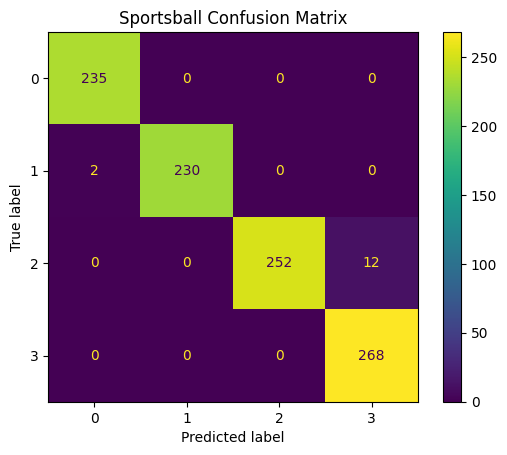

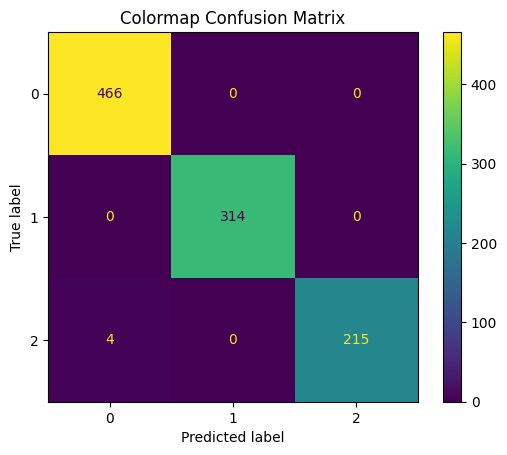

Saved predictions to pred_part3.csv


([1,
  3,
  3,
  1,
  0,
  2,
  2,
  2,
  1,
  1,
  2,
  2,
  2,
  3,
  3,
  2,
  0,
  3,
  0,
  1,
  0,
  2,
  2,
  1,
  0,
  2,
  0,
  1,
  0,
  2,
  3,
  0,
  2,
  1,
  0,
  1,
  1,
  0,
  0,
  2,
  2,
  1,
  3,
  1,
  0,
  0,
  0,
  2,
  3,
  3,
  0,
  0,
  2,
  1,
  2,
  2,
  2,
  3,
  2,
  2,
  0,
  3,
  0,
  1,
  3,
  3,
  0,
  2,
  2,
  3,
  3,
  0,
  0,
  3,
  2,
  0,
  3,
  3,
  0,
  0,
  1,
  1,
  0,
  3,
  0,
  3,
  3,
  2,
  0,
  3,
  1,
  0,
  0,
  0,
  2,
  0,
  1,
  0,
  1,
  2,
  3,
  0,
  2,
  3,
  1,
  0,
  2,
  1,
  0,
  3,
  0,
  0,
  3,
  0,
  0,
  1,
  2,
  1,
  3,
  2,
  1,
  0,
  1,
  2,
  1,
  0,
  3,
  0,
  1,
  0,
  2,
  0,
  0,
  1,
  3,
  2,
  1,
  0,
  2,
  0,
  3,
  0,
  0,
  3,
  0,
  2,
  2,
  0,
  3,
  0,
  2,
  2,
  3,
  1,
  0,
  1,
  3,
  1,
  3,
  3,
  1,
  1,
  0,
  3,
  0,
  0,
  1,
  1,
  3,
  2,
  1,
  1,
  3,
  3,
  0,
  0,
  3,
  1,
  1,
  0,
  1,
  0,
  3,
  0,
  2,
  2,
  0,
  1,
  0,
  3,
  3,
  2,
  2,
  3,
  2,
  3,
  3,
  0,
  3,
  3,


In [23]:
# Train the dual-label model
train_dual_model(model_dual, train_loader_dual, optimizer_dual, epochs=10)

# Evaluate the dual-label model
evaluate_dual_model(model_dual, test_loader_dual, 'pred_part3.csv')


### 3.5 Show Predictions for Dual-Label Model

We visualized the predictions for a few test images from the dual-label dataset.

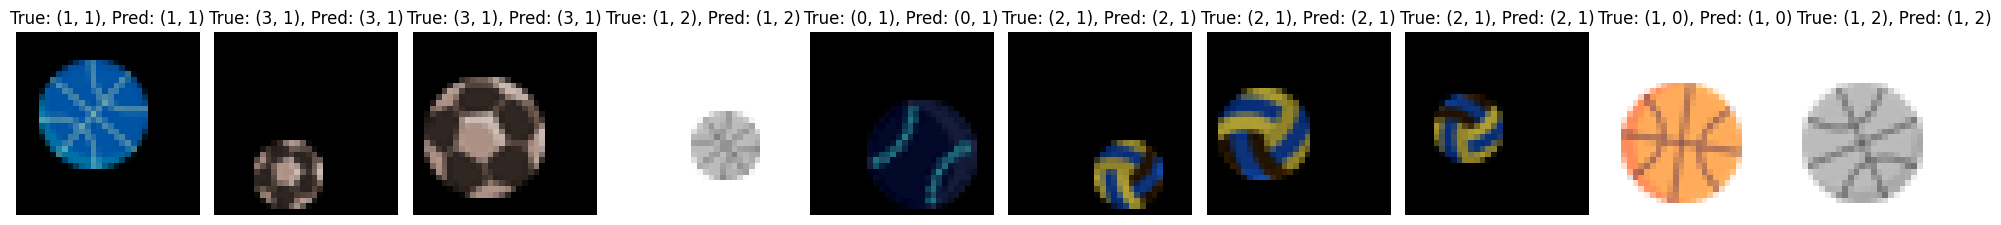

In [31]:
# Show predictions for a few dual-label test images
def show_dual_predictions(test_loader, model, num_images=5):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    with torch.no_grad():
        for i in range(num_images):
            image, (true_sportsball, true_colormap) = test_loader.dataset[i]
            image_np = image.permute(1, 2, 0).numpy()
            image = image.unsqueeze(0).to(device)
            outputs_sportsball, outputs_colormap = model(image)
            _, pred_sportsball = torch.max(outputs_sportsball.data, 1)
            _, pred_colormap = torch.max(outputs_colormap.data, 1)
            axes[i].imshow(image_np)
            axes[i].set_title(f'True: ({true_sportsball}, {true_colormap}), Pred: ({pred_sportsball.item()}, {pred_colormap.item()})')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Show predictions for a few test images from Part 3
show_dual_predictions(test_loader_dual, model_dual, num_images=10)